In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

/home/coco/opt/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
INPUT_SIZE = 3 # Number of input features - thickness, height, angle
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # 
NUM_EPOCHS = 2000

TEST_SIZE = 0.2
RANDOM_STATE = 42
device = "cpu"

In [5]:
df = pd.read_csv(r'../processed_bending_stiffness.csv')

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} duplicate row(s) from the dataset.")
print(f"Shape of dataset after removing duplicates: {df.shape}")
X = df[['Thickness', 'Height', 'Angle (deg)']]
y = df['Bending_Stiffness']

X_train, X_test, y_train, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
DATASET_SIZE = len(df) # Number of samples

Removed 685 duplicate row(s) from the dataset.
Shape of dataset after removing duplicates: (743, 4)


In [6]:
train_indices = np.random.choice(len(X_train), 5, replace=False)

print(f"Training Set Random Samples (N={5})")
print("Input Features (Thickness, Height, Angle) | Target (Stiffness)")
print("-" * 75)

for i in train_indices:
    features = X_train[i]
    target = y_train[i]
    print(f"{features} | {target:.4f}")

print("-" * 75)

test_indices = np.random.choice(len(X_test), 5, replace=False)

print(f"Testing Set Random Samples (N={5})")
print("Input Features (Thickness, Height, Angle) | Target (Stiffness)")
print("-" * 75)

for i in test_indices:
    features = X_test[i]
    target = y_test[i]
    print(f"{features} | {target:.4f}")

print("-" * 75)

Training Set Random Samples (N=5)
Input Features (Thickness, Height, Angle) | Target (Stiffness)
---------------------------------------------------------------------------
[ 6.437 59.929 48.   ] | 4266.1253
[ 3.263 45.038 52.6  ] | 1156.1898
[ 3.67  98.237 61.7  ] | 6257.2781
[ 4.917 55.96  52.4  ] | 2812.6574
[  7.115 126.099  63.9  ] | 20902.2400
---------------------------------------------------------------------------
Testing Set Random Samples (N=5)
Input Features (Thickness, Height, Angle) | Target (Stiffness)
---------------------------------------------------------------------------
[ 8.087 78.594 53.1  ] | 9295.4400
[  6.431 104.776  65.7  ] | 13297.6110
[  3.781 126.442  65.1  ] | 10841.8119
[ 6.099 29.177 66.   ] | 1046.9589
[ 7.911 47.381 40.3  ] | 3503.1638
---------------------------------------------------------------------------


In [7]:
model = nn.Sequential(
        nn.Linear(INPUT_SIZE, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        # Output Layer
        nn.Linear(16, 1)
).to(device)

In [8]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Convert TESTING data to PyTorch Tensors
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
print(test_dataset.tensors)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


(tensor([[  7.2360,  51.7390,  46.9000],
        [  6.7130, 117.3350,  69.5000],
        [  8.1800,  93.6900,  64.9000],
        [  5.5710,  24.4360,  64.9000],
        [  4.4270,  26.1590,  50.9000],
        [  3.7590,  30.8140,  55.8000],
        [  5.6000,  51.9450,  46.7000],
        [  6.0890,  40.4540,  57.7000],
        [  6.6090,  46.4380,  59.6000],
        [  7.2820,  84.5030,  65.3000],
        [  8.4580,  46.6790,  35.0000],
        [  5.6550, 123.5160,  68.5000],
        [  5.0020,  72.7910,  51.9000],
        [  3.9200, 122.6070,  69.2000],
        [  6.6210, 117.8530,  61.9000],
        [  5.7800,  22.6240,  48.9000],
        [  5.2290,  96.3260,  67.4000],
        [  4.8580, 125.2300,  64.5000],
        [  4.3880, 119.3480,  69.6000],
        [  7.1900,  66.7440,  51.2000],
        [  3.4010,  30.3030,  55.6000],
        [  3.9680,  91.2950,  59.8000],
        [  8.4910,  79.5630,  55.0000],
        [  6.1760,  23.0150,  56.4000],
        [  4.4890,  89.2930,  53.4000],

In [13]:
mae_criterion = nn.L1Loss()  # Mean Absolute Error Loss
criterion = nn.MSELoss()  # Mean Squared Error Loss

print("\nTraining...")
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * targets.size(0)
    
    avg_train_loss = running_loss / len(X_train)
    
# --- Final Evaluation on TEST SET ---
print("\n--- Final Evaluation on Test Set ---")
model.eval()
total_squared_error = 0.0
total_absolute_error = 0.0
total_samples = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        # MSE loss
        mse_loss = criterion(outputs, targets)
        total_squared_error += mse_loss.item() * targets.size(0)
        
        # MAE loss
        mae_loss = mae_criterion(outputs, targets)
        total_absolute_error += mae_loss.item() * targets.size(0)
        
        total_samples += targets.size(0)
        all_targets.append(targets.cpu())
        all_predictions.append(outputs.cpu())

# Concatenate all targets and predictions
targets_tensor = torch.cat(all_targets)
predictions_tensor = torch.cat(all_predictions)

# Calculate metrics
mean_squared_error = total_squared_error / total_samples
root_mean_squared_error = np.sqrt(mean_squared_error)
mean_absolute_error = total_absolute_error / total_samples

# R-squared
ss_residual = total_squared_error
target_mean = targets_tensor.mean()
ss_total = ((targets_tensor - target_mean) ** 2).sum().item()
r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else 0.0

print(f'\nTest Set Metrics:')
print(f'MSE: {mean_squared_error:.4f}')
print(f'RMSE: {root_mean_squared_error:.4f}')
print(f'MAE: {mean_absolute_error:.4f}')
print(f'R-squared (R²): {r_squared:.4f}')
print("\nTraining and Evaluation complete.")


Training...

--- Final Evaluation on Test Set ---

Test Set Metrics:
MSE: 735769.7190
RMSE: 857.7702
MAE: 605.8828
R-squared (R²): 0.9744

Training and Evaluation complete.


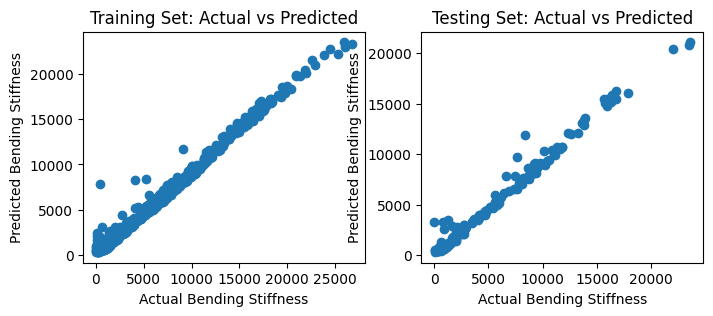

In [14]:

array_y_train_pred = model(X_train_tensor).detach().numpy()
array_y_train = y_train_tensor.detach().numpy()
from matplotlib import pyplot
pyplot.figure(figsize=(8, 3))
pyplot.subplot(1, 2, 1)
pyplot.plot(array_y_train, array_y_train_pred, 'o')
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Training Set: Actual vs Predicted')
pyplot.subplot(1, 2, 2)
array_y_test_pred = model(X_test_tensor).detach().numpy()
array_y_test = y_test_tensor.detach().numpy()
pyplot.plot(array_y_test, array_y_test_pred, 'o')
pyplot.xlabel('Actual Bending Stiffness')
pyplot.ylabel('Predicted Bending Stiffness')
pyplot.title('Testing Set: Actual vs Predicted')
pyplot.show()

In [ ]:
print(model(torch.tensor([[3.5, 50, 60]], dtype=torch.float32)))  # Example bending stiffness input

tensor([[1585.3643]], grad_fn=<AddmmBackward0>)
